In [10]:
import sys
sys.path.append("src")
import dataloader
import model
import modules
import torch
from torch import nn
import numpy as np
import anndata as ad
from tqdm import trange
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
seed = 0
torch.manual_seed(seed)
preload = True
AnnData_path = "/project/compbio-lab/scHi-C/Ramani2017/sample/AnnData_files/res_1mb/raw.h5ad"
resolution = 1_000_000
chromosome_size_filepath = "/project/compbio-lab/genomes_supp/hg19.chrom.sizes"
include_diag = False
chr = 1
chr_name = 'chr{}'.format(chr)
device = "cpu"
hidden1 = 32
hidden2 = int(hidden1 / 2)
GCN_version = "binary"
linear_nbr = True
sample_size = None
dataset = dataloader.scHiCDataset(AnnData_path, 
                                  resolution, 
                                  chromosome_size_filepath, 
                                  chr_name, 
                                  preload_prop_maps = preload,
                                  include_diag = include_diag,
                                  GCN_version = GCN_version,
                                  GCN_linear_nbr = linear_nbr,
                                  output_version = "count",
                                  sample = sample_size
                                 )

100%|████████████████████████████████████████| 620/620 [00:03<00:00, 166.98it/s]


In [ ]:
dataset.calculate_avg_pool_depth()

features = torch.eye(num_nodes).to(device)
ut_idx = np.triu_indices(len(dataset.good_bins), 1)



In [6]:
num_nodes = dataset.chromosome_size
likelihood = "poisson"
scale_type = "pool"
decoder_type = "combined"
my_model = model.GVAE(num_nodes,
                      hidden1,
                      hidden2,
                      good_bins = dataset.good_bins,
                      likelihood = likelihood,
                      scale_type = scale_type,
                      distance_effect = True,
                      decoder_type = decoder_type,
                      variational = True,
                      var_eps = 0.001,
                      GCN1_act = nn.ReLU(),
                      self_adj_input = False,
                      device = device)

my_model = my_model.double()
my_model = my_model.to(device)

In [7]:
lr = 0.001
epoch = 20
optimizer = torch.optim.Adam(my_model.parameters(), lr=lr)
losses = []
validation_losses = []
for epoch in trange(epoch):
    epoch_losses = []
    epoch_validation_losses = []
    for idx in dataset.training_index:
        prop_adj =  dataset.GCN_prop_maps[idx].to_dense().to(device)
        out_adj = dataset.contact_maps[idx].to_dense().to(device)
        outs = my_model(adj = torch.Tensor.double(out_adj), prop_adj = torch.Tensor.double(prop_adj))
        my_model.zero_grad()
        loss = outs[0]
        epoch_losses.append(loss.detach().to('cpu').numpy().item())
        loss.backward()
        optimizer.step()
    
    for idx in dataset.validation_index:
        prop_adj =  dataset.GCN_prop_maps[idx].to_dense().to(device)
        out_adj = dataset.contact_maps[idx].to_dense().to(device)
        outs = my_model(adj = torch.Tensor.double(out_adj), prop_adj = torch.Tensor.double(prop_adj))
        loss = outs[0]
        epoch_validation_losses.append(loss.detach().to('cpu').numpy().item())
    losses.append(np.mean(epoch_losses))
    validation_losses.append(np.mean(epoch_validation_losses))

100%|███████████████████████████████████████████| 20/20 [23:45<00:00, 71.28s/it]


In [8]:
ut_idx = np.triu_indices(len(dataset.good_bins), 1)
recons = []
imp_array = []
for idx in range(dataset.num_cells):
    with torch.no_grad():
        prop_adj =  dataset.GCN_prop_maps[idx].to_dense().to(device)
        out_adj = dataset.contact_maps[idx].to_dense().to(device)
        scale_graph, *_ = my_model.get_recon_adj(adj = torch.Tensor.double(out_adj), prop_adj = torch.Tensor.double(prop_adj))
        scale_graph = scale_graph.cpu()
        imp_array.append(scale_graph.numpy()[np.ix_(dataset.good_bins, dataset.good_bins)][ut_idx].reshape(1, -1))
        recons.append(scale_graph.numpy() + scale_graph.numpy().T)
imp_array = np.concatenate(imp_array, axis = 0)
if imp_array.shape[0] != dataset.num_cells:
    imp_array = imp_array.reshape(dataset.num_cells, -1)
np.save("Ramani_imp", imp_array)

Text(0, 0.5, 'Loss (NLL)')

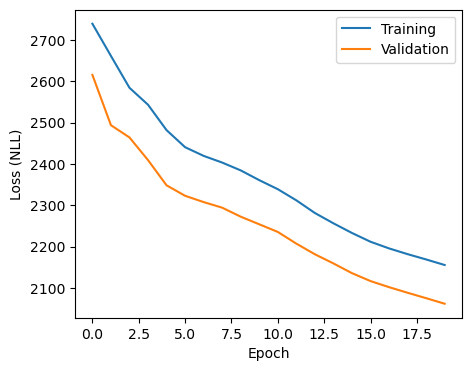

In [32]:
figure = plt.figure(figsize = (5, 4))
ax = sns.lineplot(losses, label = "Training")
ax = sns.lineplot(validation_losses, label = "Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (NLL)")

Text(0.5, 1.0, 'Cell 0 (Imputed by contactVI)')

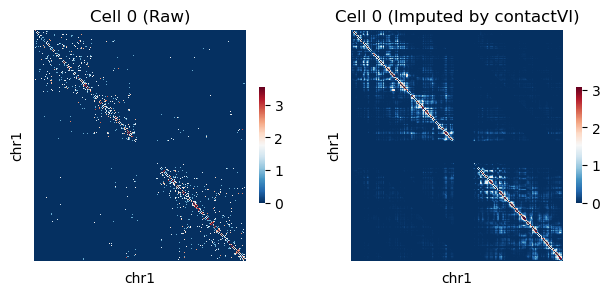

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (7.5, 3))
sns.heatmap(np.arcsinh(dataset.contact_maps[0].to_dense()), ax = axs[0], cmap = "RdBu_r", cbar_kws = {"shrink": 0.5})
sns.heatmap(np.arcsinh(recons[0]), ax = axs[1], cmap = "RdBu_r", cbar_kws = {"shrink": 0.5})
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(chr_name)
    axs[i].set_ylabel(chr_name)
axs[0].set_title("Cell 0 (Raw)")
axs[1].set_title("Cell 0 (Imputed by contactVI)")